In [ ]:
!pip install optuna
import optuna
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
# from sklearn.linear_model import LogisticRegression

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 8.6 MB/s eta 0:00:00


In [ ]:
# 테이터 확인
df_train = pd.read_csv('/content/drive/MyDrive/DACON/채무 불이행 여부 예측 해커톤: 불이행의 징후를 찾아라!/train.csv')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   UID                10000 non-null  object 
 1   주거 형태              10000 non-null  object 
 2   연간 소득              10000 non-null  float64
 3   현재 직장 근속 연수        10000 non-null  object 
 4   체납 세금 압류 횟수        10000 non-null  float64
 5   개설된 신용계좌 수         10000 non-null  int64  
 6   신용 거래 연수           10000 non-null  float64
 7   최대 신용한도            10000 non-null  float64
 8   신용 문제 발생 횟수        10000 non-null  int64  
 9   마지막 연체 이후 경과 개월 수  10000 non-null  int64  
 10  개인 파산 횟수           10000 non-null  int64  
 11  대출 목적              10000 non-null  object 
 12  대출 상환 기간           10000 non-null  object 
 13  현재 대출 잔액           10000 non-null  float64
 14  현재 미상환 신용액         10000 non-null  float64
 15  월 상환 부채액           10000 non-null  float64
 16  신용 점수              1000

In [ ]:
# 결측치가 없음을 확인
# object 데이터 LabelEncoding 변환
column_list = list(df_train.columns)
column_list = column_list[1:2] + column_list[3:4] + column_list[11:13]

encoder = LabelEncoder()
for i in column_list:
  encoder.fit(df_train[i])
  df_train[i] = encoder.transform(df_train[i])

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   UID                10000 non-null  object 
 1   주거 형태              10000 non-null  int64  
 2   연간 소득              10000 non-null  float64
 3   현재 직장 근속 연수        10000 non-null  int64  
 4   체납 세금 압류 횟수        10000 non-null  float64
 5   개설된 신용계좌 수         10000 non-null  int64  
 6   신용 거래 연수           10000 non-null  float64
 7   최대 신용한도            10000 non-null  float64
 8   신용 문제 발생 횟수        10000 non-null  int64  
 9   마지막 연체 이후 경과 개월 수  10000 non-null  int64  
 10  개인 파산 횟수           10000 non-null  int64  
 11  대출 목적              10000 non-null  int64  
 12  대출 상환 기간           10000 non-null  int64  
 13  현재 대출 잔액           10000 non-null  float64
 14  현재 미상환 신용액         10000 non-null  float64
 15  월 상환 부채액           10000 non-null  float64
 16  신용 점수              1000

In [ ]:
# UID열 제거
df_train.drop(columns = ['UID'], inplace = True)

In [ ]:
# 각 데이터별 상관도 확인
df_train.corr()

,주거 형태,연간 소득,현재 직장 근속 연수,체납 세금 압류 횟수,개설된 신용계좌 수,신용 거래 연수,최대 신용한도,신용 문제 발생 횟수,마지막 연체 이후 경과 개월 수,개인 파산 횟수,대출 목적,대출 상환 기간,현재 대출 잔액,현재 미상환 신용액,월 상환 부채액,신용 점수,채무 불이행 여부
주거 형태,1.000000,0.252002,0.019441,-0.019306,0.112734,0.271932,0.222704,-0.045177,-0.152461,-0.041540,0.202856,0.199147,0.285540,0.118354,0.195906,-0.086384,-0.079707
연간 소득,0.252002,1.000000,-0.019093,0.090106,0.201558,0.308904,0.377923,0.055681,-0.065386,-0.017336,0.135051,0.109321,0.403319,0.336916,0.416631,0.045491,-0.120499
현재 직장 근속 연수,0.019441,-0.019093,1.000000,0.124652,0.094420,0.017668,-0.042051,0.269788,0.104455,0.382141,-0.013289,0.063207,0.013257,-0.032771,-0.033502,-0.079953,0.095198
체납 세금 압류 횟수,-0.019306,0.090106,0.124652,1.000000,0.013270,0.090488,-0.031614,0.510265,0.132386,0.225035,0.028348,-0.024957,0.109320,-0.069903,0.022609,-0.007147,-0.030419
개설된 신용계좌 수,0.112734,0.201558,0.094420,0.013270,1.000000,0.139979,0.271732,0.066667,-0.043846,0.138699,0.004346,-0.001127,0.168379,0.250217,0.292177,0.079615,0.169900
신용 거래 연수,0.271932,0.308904,0.017668,0.090488,0.139979,1.000000,0.275284,0.128106,-0.048344,0.133616,0.164332,-0.004799,0.233531,0.186893,0.232618,0.116424,-0.108856
최대 신용한도,0.222704,0.377923,-0.042051,-0.031614,0.271732,0.275284,1.000000,-0.092891,-0.119547,-0.116278,0.097686,0.110728,0.361259,0.392104,0.379351,0.049756,-0.044997
신용 문제 발생 횟수,-0.045177,0.055681,0.269788,0.510265,0.066667,0.128106,-0.092891,1.000000,0.227206,0.600116,0.028956,-0.110826,0.017065,-0.093040,-0.024605,0.065530,0.044847
마지막 연체 이후 경과 개월 수,-0.152461,-0.065386,0.104455,0.132386,-0.043846,-0.048344,-0.119547,0.227206,1.000000,0.243908,-0.049920,-0.173601,-0.144126,-0.100230,-0.117031,0.112091,-0.012058
개인 파산 횟수,-0.041540,-0.017336,0.382141,0.225035,0.138699,0.133616,-0.116278,0.600116,0.243908,1.000000,-0.016389,-0.128475,-0.085709,-0.082009,-0.065000,0.093226,0.115900


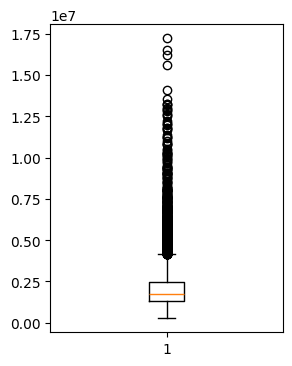

In [ ]:
# 각 데이터별 boxplot 시각화
plt.figure(figsize = (3,4))
plt.boxplot(df_train['연간 소득'])
plt.show()

In [ ]:
# 데이터 이상치 제거
df_train.drop(index = df_train[df_train['연간 소득'] >= 15000000].index, inplace = True)
df_train.drop(index = df_train[df_train['개설된 신용계좌 수'] >= 35].index, inplace = True)
df_train.drop(index = df_train[df_train['신용 거래 연수'] >= 50].index, inplace = True)
df_train.drop(index = df_train[df_train['월 상환 부채액'] >= 140000].index, inplace = True)

# 총 7개 행 제거

In [ ]:
# Optuna를 사용하기 위한 모델 정의
def prediction_model(trial):
  x = df_train.drop(columns = ['현재 미상환 신용액', '채무 불이행 여부'])
  y = df_train['채무 불이행 여부']

  # 데이터 분할
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

  # optuna에 사용할 하이퍼파라미터 설정
  params = {
      'n_estimators':trial.suggest_int('n_estimators', 100, 5000),
      'learning_rate':trial.suggest_float('learning_rate', 1e-3, 3e-1, log = True),
      'max_depth':trial.suggest_int('max_depth', 3, 15),
      'min_child_weight':trial.suggest_int('min_child_weight', 1, 10),
      'reg_alpha':trial.suggest_int('reg_alpha', 0, 10),
      'reg_lambda':trial.suggest_int('reg_alpha', 0, 10)
  }

  # 로지스틱 회귀모델 객체 생성
  xgb_cls = XGBClassifier(**params)
  xgb_cls.fit(x_train, y_train)

  # 예측값 도출
  y_pred = xgb_cls.predict(x_test)
  ra_score = roc_auc_score(y_test, y_pred)

  return ra_score

In [ ]:
# prediction_model의 최적 하이퍼파라미터 찾기
study = optuna.create_study(direction = 'maximize')
study.optimize(prediction_model, n_trials = 200)

optimum_params = study.best_params
print(optimum_params)

[I 2025-03-18 07:57:26,961] A new study created in memory with name: no-name-ef972209-3941-43fa-8a2b-c70966b70d64
[I 2025-03-18 07:57:27,480] Trial 0 finished with value: 0.654566037810177 and parameters: {'n_estimators': 681, 'learning_rate': 0.20744260399572123, 'max_depth': 3, 'min_child_weight': 2, 'reg_alpha': 7}. Best is trial 0 with value: 0.654566037810177.
[I 2025-03-18 07:57:36,376] Trial 1 finished with value: 0.6076696789798579 and parameters: {'n_estimators': 3340, 'learning_rate': 0.0010908145428720991, 'max_depth': 3, 'min_child_weight': 1, 'reg_alpha': 3}. Best is trial 0 with value: 0.654566037810177.
[I 2025-03-18 07:57:43,448] Trial 2 finished with value: 0.6612861290462365 and parameters: {'n_estimators': 4388, 'learning_rate': 0.01884352659131044, 'max_depth': 15, 'min_child_weight': 9, 'reg_alpha': 9}. Best is trial 2 with value: 0.6612861290462365.
[I 2025-03-18 07:57:49,969] Trial 3 finished with value: 0.653650131772288 and parameters: {'n_estimators': 1268, 'l

{'n_estimators': 1183, 'learning_rate': 0.09836420967947834, 'max_depth': 9, 'min_child_weight': 10, 'reg_alpha': 10}


In [ ]:
# test 데이터 불러오기
df_test = pd.read_csv('/content/drive/MyDrive/DACON/채무 불이행 여부 예측 해커톤: 불이행의 징후를 찾아라!/test.csv')

# test 데이터 확인
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2062 entries, 0 to 2061
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   UID                2062 non-null   object 
 1   주거 형태              2062 non-null   object 
 2   연간 소득              2062 non-null   float64
 3   현재 직장 근속 연수        2062 non-null   object 
 4   체납 세금 압류 횟수        2062 non-null   float64
 5   개설된 신용계좌 수         2062 non-null   int64  
 6   신용 거래 연수           2062 non-null   float64
 7   최대 신용한도            2062 non-null   float64
 8   신용 문제 발생 횟수        2062 non-null   int64  
 9   마지막 연체 이후 경과 개월 수  2062 non-null   int64  
 10  개인 파산 횟수           2062 non-null   int64  
 11  대출 목적              2062 non-null   object 
 12  대출 상환 기간           2062 non-null   object 
 13  현재 대출 잔액           2062 non-null   float64
 14  현재 미상환 신용액         2062 non-null   float64
 15  월 상환 부채액           2062 non-null   float64
 16  신용 점수              2062 

In [ ]:
# train 데이터 중 object 데이터 LabelEncoding 변환
test_column_list = list(df_test.columns)
test_column_list = test_column_list[1:2] + test_column_list[3:4] + test_column_list[11:13]

encoder = LabelEncoder()
for i in test_column_list:
  encoder.fit(df_test[i])
  df_test[i] = encoder.transform(df_test[i])

df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2062 entries, 0 to 2061
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   UID                2062 non-null   object 
 1   주거 형태              2062 non-null   int64  
 2   연간 소득              2062 non-null   float64
 3   현재 직장 근속 연수        2062 non-null   int64  
 4   체납 세금 압류 횟수        2062 non-null   float64
 5   개설된 신용계좌 수         2062 non-null   int64  
 6   신용 거래 연수           2062 non-null   float64
 7   최대 신용한도            2062 non-null   float64
 8   신용 문제 발생 횟수        2062 non-null   int64  
 9   마지막 연체 이후 경과 개월 수  2062 non-null   int64  
 10  개인 파산 횟수           2062 non-null   int64  
 11  대출 목적              2062 non-null   int64  
 12  대출 상환 기간           2062 non-null   int64  
 13  현재 대출 잔액           2062 non-null   float64
 14  현재 미상환 신용액         2062 non-null   float64
 15  월 상환 부채액           2062 non-null   float64
 16  신용 점수              2062 

In [ ]:
# 최적 하이퍼파라미터를 이용한 객체 생성
xgb_cls = XGBClassifier(**optimum_params)

# 먼저 train 데이터를 통해 모델학습
x = df_train.drop(columns = ['채무 불이행 여부'])
y = df_train['채무 불이행 여부']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

xgb_cls.fit(x_train, y_train)

# 최적 하이퍼파라미터를 이용한 학습모델에 test 데이터를 반영하여 채무 불이행 여부 도출
x = df_test.drop(columns = ['UID'])
y_default = xgb_cls.predict(x)

df_trial = pd.DataFrame({'UID':df_test['UID'], '채무 불이행 확률':y_default})
df_trial

,UID,채무 불이행 확률
0,TEST_0000,0
1,TEST_0001,0
2,TEST_0002,0
3,TEST_0003,0
4,TEST_0004,0
...,...,...
2057,TEST_2057,0
2058,TEST_2058,0
2059,TEST_2059,0
2060,TEST_2060,0


In [ ]:
df_trial.to_csv('/content/drive/MyDrive/DACON/채무 불이행 여부 예측 해커톤: 불이행의 징후를 찾아라!/submission_0318.csv', index = False)